In [74]:
import numpy as np
from scipy import ndimage
from astropy.io import fits
import matplotlib.pyplot as plt
import l2_processor.aspiics_detector  as det
import l2_processor.aspiics_optics    as optics
import l2_processor.aspiics_get_opse  as opse
import l2_processor.parameters        as par
import os

def read_fits_image_array(filename):
    """See https://docs.astropy.org/en/stable/io/fits/ for more info"""
    with fits.open(filename, do_not_scale_image_data=True) as hdul:             
       imagedata = hdul[0].data
       header    = hdul[0].header
    return imagedata, header

def write_fits(imagedata, inputfile, outputfile):
    with fits.open(inputfile) as hdul:
       hdul[0].data = imagedata
       hdul.writeto(outputfile)

# *************** Parsing arguments *****************

# argparse placeholder
class args:
    file = 'testfile.fits'
    diff = 'None'
    save_diff = False
    cal = 'l2_config.json'
    filter = 'None'
    outdir = './output/'
    mark_IO = False
    mark_suncenter = False

#outputdir = './output/'
outputdir = args.outdir
mark_io   = args.mark_IO
mark_sun  = args.mark_suncenter



In [75]:
# ***************** Input image *******************
# filename='../data/Orbit273/P3SC_L1_20251217_222845/aspiics_wb_l1_1110A00A000112_20250716T190406.fits'
filename='../data/Orbit273/P3SC_L1_20251217_222845/aspiics_wb_l1_11108000000E11_20250716T164136.fits'
#filename = sys.argv[1]
# filename=args.file

suffix = "fixnonlin_flat_banding12_hotpix"


Im, header = read_fits_image_array(filename)
print("%*******************************************************************************")
print("% L2_MASTER: processing "+os.path.basename(filename))

## *** the checks should be implemented, probably via KeyError exeption ***
if args.filter != "None":
    filter=args.filter.strip()
    header.set('FILTER',filter)
    print("%    Forcing filter **",filter,"**",sep='')
else:
    filter=header['FILTER']            # filter='Wideband' # should be retrieved from the header
#print("filter :  **",filter,"**")
if 'Unknown' in filter:
    filter='Fe XIV'
    header.set('FILTER',"Fe XIV")
    print("%    'Unknown' is in fits header. Forcing to 'Fe XIV'")
print("%    Using filter:  **",filter,"**",sep='')
t_exp =header['EXPTIME']           # t_exp =1.0        # should be retrieved from the header
pixscale = header['CDELT1']        #
if 'BLANK' not in header:
    header.set('BLANK',-32768)
    print("%    No BLANK value in header. Setting to -32768")
else:
    BLANK =header['BLANK']
    print("%    Using BLANK value from header: ",BLANK,sep='')
if 'BZERO' not in header:
    header.set('BZERO',0.0)
if 'BSCALE' not in header:
    header.set('BSCALE',1.0)

##### *** this exists only in sergeis test data ***
#DIFFR_filename = header['DIFFR1'] + '.' + header['DIFFR2']
#print("% L2_MASTER. Filename: "+filename)
#print("       header diffraction: "+DIFFR_filename)
#DIFFR_filename="ID_phiF.z144348.A1048576pts.rho50.IO1748mmH.C2425.LA235.JJ4096.T00_S0000.cart9.fits"
if args.diff != 'None':
    DIFFR_filename=args.diff.strip()
    print("%    Using diffraction file:    ",DIFFR_filename,sep='')

### *** trying to match to git-version of l2_master ***
#params = par.readparams("calibr_data.json",[])
params=par.readparams(args.cal,[])
print("%    Using calibration file:    ",args.cal,sep='')

#  read filter-specific parameters and put then into main dictionary
if filter=='Fe XIV':
   params1=params['calib_data']['Fe XIV']
elif filter=='He I':
   params1=params['calib_data']['He I']
elif filter=='Wideband':
   params1=params['calib_data']['Wideband']
elif filter=='Polarizer 0':
   params1=params['calib_data']['Polarizer 0']
elif filter=='Polarizer 60':
   params1=params['calib_data']['Polarizer 60']
elif filter=='Polarizer 120':
   params1=params['calib_data']['Polarizer 120']
params['calib_data'].update(params1)

### *** this should be retrieved from the repository, as Level-1 data still has no this info *** 
#Aphot =2.1718226e+10  # for WBF.  Here calculated as 2.08e+20[photon/s/cm2/sr] * T_f * dS_pix * Apert * QE_f * gain # T=0.393 QE=0.65
##Aphot =3.4428314e+8   # for Fe XIV                    3.742e+18[photon/s/cm2/sr] * T_f * dS_pix * Apert * QE_f * gain # T=0.369 QE=0.61
##Aphot =1.3899817e+9   # for He I                     1.548e+19[photon/s/cm2/sr] * T_f * dS_pix * Apert * QE_f * gain # T=0.338 QE=0.65


#x_IO = 1024.5-1.0 # center of IO in pix, converting from FITS (1->2048) to python (0->2047) standard
#y_IO = 1024.5-1.0 
#R_IO = 1.748      # radius in mm
#eta1  = 2.0       # additional margin for the saturation. Currently comes from nowhere !!!!
#eta2  = 4.0       # margin for the comparing of optical signal with its median value
#params = {'calib_data': {'Aphot': Aphot, 'x_IO': x_IO, 'y_IO': y_IO, 'R_IO': R_IO, 'eta1': eta1, 'eta2': eta2, 'gain': 0.119, 'readout_noise': 6.013}}

#params['calib_data']['Aphot']=Aphot
#params['calib_data']['x_IO']=x_IO
#params['calib_data']['y_IO']=y_IO
Aphot=params['calib_data']['Aphot']    
x_IO = params['calib_data']['x_IO']
y_IO = params['calib_data']['y_IO']
R_IO = params['calib_data']['R_IO']
eta1=params['calib_data']['eta1']  #=eta1
eta2=params['calib_data']['eta2']  #=eta2
header.set('CDELT1',params['calib_data']['pixscale'])
header.set('CDELT2',params['calib_data']['pixscale'])


Im_orig = Im      # temporary, to compare with the processed 
nlcorr_msg="No nonlinearity" ; dc_msg="No dark current" ; bias_msg="No bias" ; flat_msg="No flat"

### $$$ ***      PLEASE DO NOT SPLIT THIS PART OF CODE INTO PIECES/FILES/PROCEDURES      *** $$$ ###
### $$$ ***  VEUILLEZ NE PAS DIVISER CETTE PARTIE DU CODE EN MORCEAUX/FILES/PROCEDURES   *** $$$ ###
### $$$ *** SPLITS DIT DEEL VAN DE CODE ALSTUBLIEFT NIET IN STUKKEN/BESTANDEN/PROCEDURES *** $$$ ###

# ***************** this part should correspond to the lines 1--6 of the pseudo-code of DPM *******************
filefake='test'           
gain = det.gain(header,params)                                             # 
dc,   dc_msg   = det.darkcurrent(header,params)
dc             = dc/gain                                                   # original calibration data is in [DN]. We need [el] here
bias, bias_msg = det.bias(header,params)
flat, flat_msg = det.flat(header,params)
HotPixels      = det.hot_pixels(header,params,1.0)                               
Vread = np.ones((2048,2048))*(det.readout_noise(header,params)/gain)**2    # readout noise variance in DN
Vdc   = (dc*t_exp)  # np.sqrt(dc*t_exp)                                    # dark current variance, el/sec -> el         ?? -> sqrt()  ??
#Vphot = np.full((2048,2048),1.0/gain)                                      # wrong: variance of photons = number of photons ~ Im/gain (since qe~1), but Im contains noise also
Vphot = np.full((2048,2048),1.0)                                           # variance of photons = number of photons = numbers of photoelectrons. Which is calculated from Im in correspondent place
                                                                           # Vphot==1 and will go as a factor to the photovariance;
#vign  = optics.vignetting(pixscale,x_IO,y_IO,R_IO,verbose=False)
vign, vign_msg = optics.vignetting2(header,params)                         # vignetting takes into account variation of R_IO with polar angle
BlankIdx = (Im == BLANK)

# set bad pixels to NaN
Im = np.float32(Im)
Im[BlankIdx]  = np.nan

# ***************** this part should correspond to the lines 8--25 of the pseudo-code of DPM *******************
Im   = (Im - bias)/gain

Im, satlevel, nlcorr_msg = det.get_nlcorr(Im,header,params)                 # non-linearity correction, also returns saturation level in [el] to mask overexposed pixels later on 

Var  = Vread + Vdc + np.multiply(Vphot,Im)*(Im > 0)                   # Variance map for the signal, 2D array

OvrExpIdx = Im >= satlevel                                            # Boolean 2D array with overexposed pixels. Values may be larger than satlevel from B-Spline extrapolation of non-linearity curve

Im   = Im - dc*t_exp                                                  # In the original version the DC was subtracted before overexposed pixels, 
                                                                      #   but in this case at long t_exp many pixels within saturated zone were marked as normal


### When the optical part is commented out we should multiply by gain (introduced during DC subtraction)
### Do not forget to comment vignetting below                                                    ###
# Im = Im*gain
#Im = np.divide(Im,flat)


### This is the optical part: radiometric calibration, subtraction of diffraction/ghost/scattering ###
### Do not forget to uncomment vignetting below                                                    ###

Im   = np.divide(Im,            flat*(Aphot/gain*t_exp))           # here convert units to [MSB] (analog of [photon s-1 cm-2 sr-1]), as the gain was taken into account before
Var  = np.divide(Var, np.square(flat*Aphot/gain*t_exp))


%*******************************************************************************
% L2_MASTER: processing aspiics_wb_l1_11108000000E11_20250716T164136.fits
%    Using filter:  **Wideband**
%    Using BLANK value from header: -32768
%    Using calibration file:    l2_config.json
% aspiics_detector.darkcurrent: using files dark_{A,B,C}2.fits from the
   ./calibration-data/calibration_data_20100101000000_20241205000000/ folder. Resulting units [DN/sec].
   APS_TEMP=-21.92 C
% aspiics_detector.bias:        using files bias_{A,B}.fits from the 
   ./calibration-data/calibration_data_20100101000000_20241205000000/ folder. Resulting units [DN].
   APS_TEMP=-21.92 C
% aspiics_detector.flat:        using file flatfield_WB.fits
% aspiics_detecotr.hot_pixels:  reading file ./calibration-data/calibration_data_20100101000000_20241205000000/hotpixels_list.fits. There are 3 pixels.
% aspiics_getector.get_nlcorr:  using file ./calibration-data/calibration_data_20100101000000_20241205000000/detector_non

Image with NaNs or uint16 type passed to vectorized nanmedian.
Cropped region for vectorized nanmedian: rows 224-832, cols 448-1600


y:\06_SpaceStuff\Spacecraft\Proba3\aspiics_processing\.venv\Lib\site-packages\scipy\ndimage\_filters.py:183: RuntimeWarning: All-NaN slice encountered
  return footprinted_function(xp.asarray(view), **kwargs)
y:\06_SpaceStuff\Spacecraft\Proba3\aspiics_processing\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1216: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


Image with NaNs or uint16 type passed to vectorized nanmedian.
Cropped region for vectorized nanmedian: rows 224-832, cols 448-1600


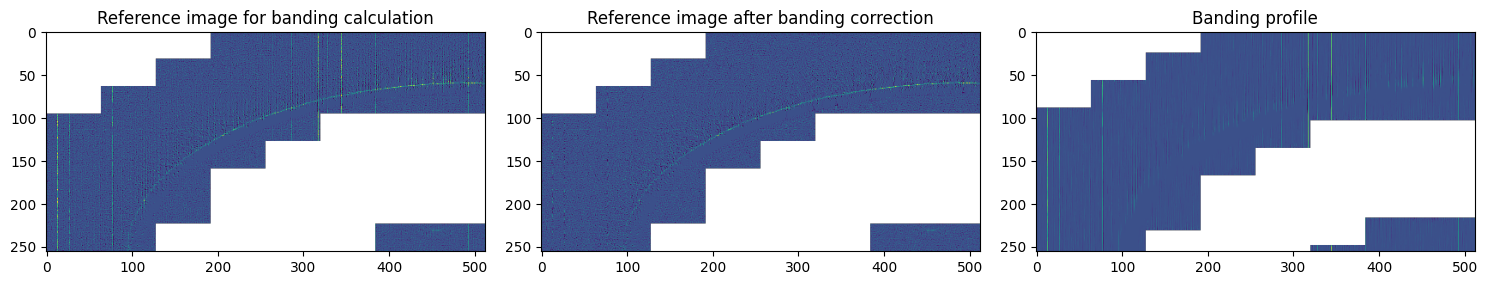

Image with NaNs or uint16 type passed to vectorized nanmedian.
Cropped region for vectorized nanmedian: rows 224-832, cols 448-1600
Image with NaNs or uint16 type passed to vectorized nanmedian.
Cropped region for vectorized nanmedian: rows 224-832, cols 448-1600


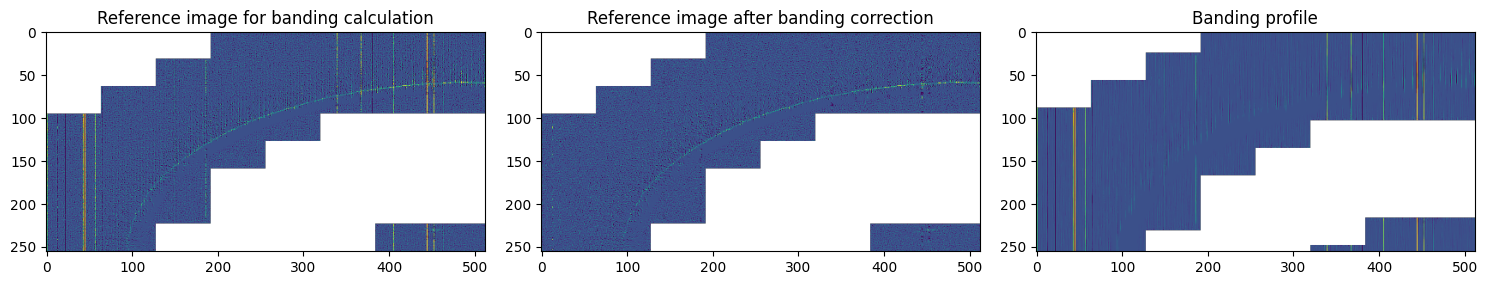

Image with NaNs or uint16 type passed to vectorized nanmedian.
Cropped region for vectorized nanmedian: rows 224-832, cols 448-1600
Image with NaNs or uint16 type passed to vectorized nanmedian.
Cropped region for vectorized nanmedian: rows 224-832, cols 448-1600


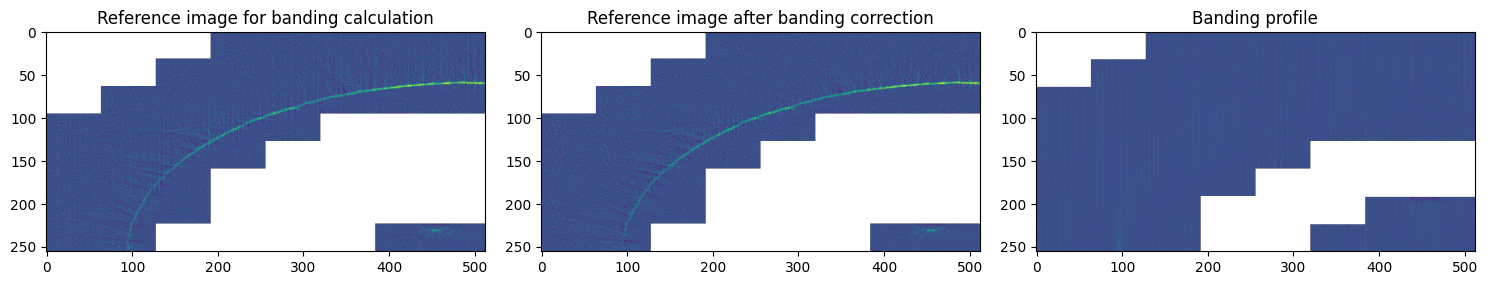

Image with NaNs or uint16 type passed to vectorized nanmedian.
Cropped region for vectorized nanmedian: rows 224-832, cols 448-1600
Image with NaNs or uint16 type passed to vectorized nanmedian.
Cropped region for vectorized nanmedian: rows 224-832, cols 448-1600


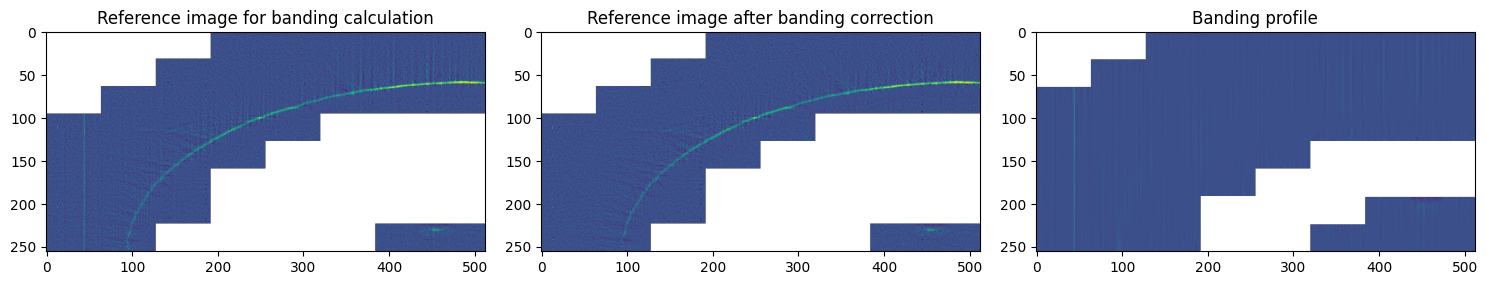

Image with NaNs or uint16 type passed to vectorized nanmedian.
Cropped region for vectorized nanmedian: rows 224-832, cols 448-1600
Image with NaNs or uint16 type passed to vectorized nanmedian.
Cropped region for vectorized nanmedian: rows 224-832, cols 448-1600


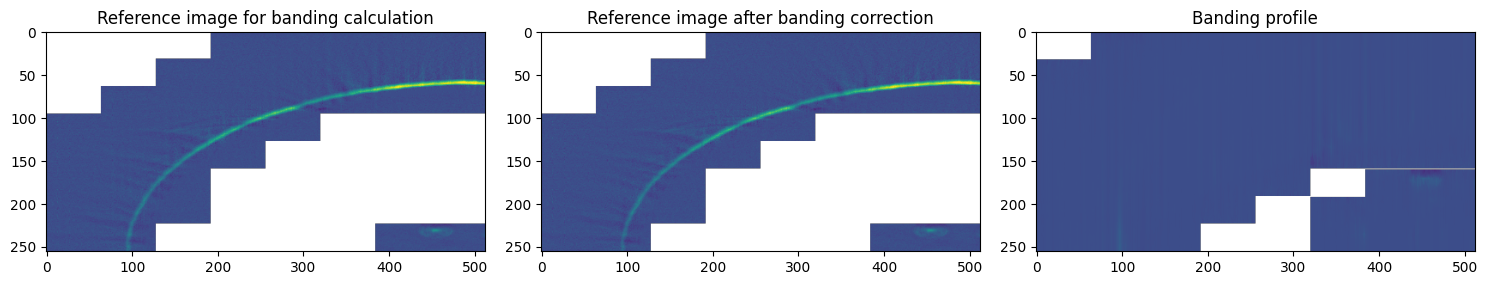

Image with NaNs or uint16 type passed to vectorized nanmedian.
Cropped region for vectorized nanmedian: rows 224-832, cols 448-1600
Image with NaNs or uint16 type passed to vectorized nanmedian.
Cropped region for vectorized nanmedian: rows 224-832, cols 448-1600


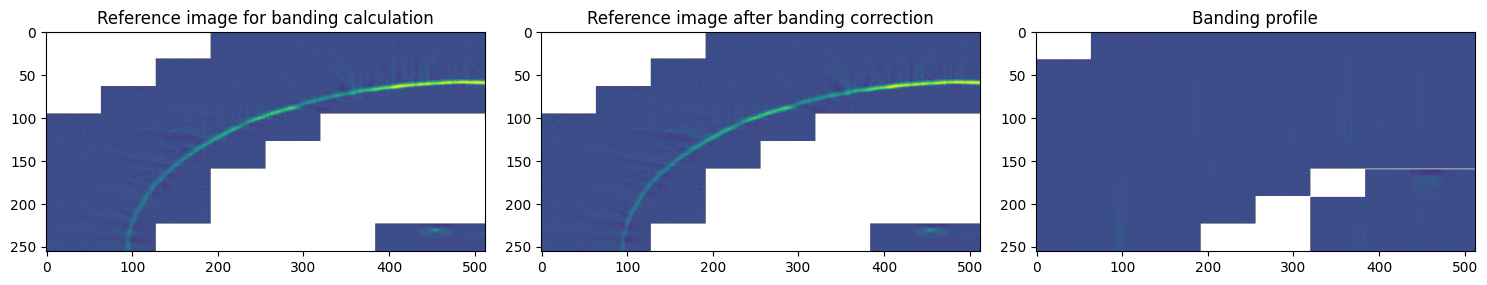

Banding correction took 20.32 seconds


In [76]:
from matplotlib.pyplot import axes
from scipy.ndimage import median_filter, vectorized_filter
import time

def split_rows(Im):
    """Split image into odd and even rows for further processing"""
    Im_odd  = Im[0::2,:]   # rows 0,2,4,...  (1,3,5,... in FITS standard)
    Im_even = Im[1::2,:]   # rows 1,3,5,...  (2,4,6,... in FITS standard)
    return Im_odd, Im_even

def fast_nanmedian(img, *args, **kwargs):
    """Applies a windowed median filter to an image, handling NaN values appropriately.
    Uses vectorized_filter with np.nanmedian for images with NaNs or of uint16 type,
    otherwise uses faster standard median_filter.

    Parameters:
    -----------
    img : numpy array
        The input image to be filtered.
    *args, **kwargs :
        Additional arguments to be passed to the median filter functions.

    Returns:
    --------
    filtered_img : numpy array
        The median filtered image.
    """
    if np.ndim(img) != 2:
        raise ValueError("fast_nanmedian only supports 2D images.")

    if np.isnan(img).all():
        # if all values are NaN, return as is
        print("All NaN image passed to fast_nanmedian, returning as is.")
        return img
    elif np.isnan(img).any() or img.dtype == np.uint16:
        # if any NaNs or uint16 type, use vectorized nanmedian
        print("Image with NaNs or uint16 type passed to vectorized nanmedian.")

        mask = np.isfinite(img)

        r0 = mask.any(axis=1).argmax()
        r1 = mask.shape[0] - mask.any(axis=1)[::-1].argmax()
        c0 = mask.any(axis=0).argmax()
        c1 = mask.shape[1] - mask.any(axis=0)[::-1].argmax()
        cropped = img[r0:r1, c0:c1]

        print(f"Cropped region for vectorized nanmedian: rows {r0}-{r1}, cols {c0}-{c1}")

        # apply vectorized nanmedian to cropped region
        cropped_filtered = vectorized_filter(cropped, function=np.nanmedian, *args, **kwargs)

        # place filtered cropped region back into all-NaN image
        img_filtered = np.full_like(img, np.nan)
        img_filtered[r0:r1, c0:c1] = cropped_filtered

        return img_filtered
    else:
        # if no NaNs, use faster median filter
        return median_filter(img, *args, **kwargs)

def correct_banding(img, filter_2d=15, filter_1d=None, structures_threshold=None):
    """
    Corrects banding along the first dimension in an image using specified filtering and averaging methods.

    Parameters:
    -----------
    img : 2D numpy array
        The input image to be corrected.
    saturation_mask : 2D numpy array
        A boolean mask indicating saturated pixels in the image.
    filter_2d : int, optional
        Size of the median filter applied in 2D to remove large structures.
    filter_1d : int | False, optional
        Size of the median filter applied in 1D to remove outliers.
        Default is 4 * filter_2d.
        If False, no 1D filtering is applied and banding profile is computed for the entire line with np.nanmedian.
    structures_threshold : float, optional
        Threshold in standard deviation units to identify remaining structures.
        Default is 60 / filter_2d.

    Returns:
    --------
    corrected_img : 2D numpy array
        The banding-corrected image.

    """
    if structures_threshold is None:
        structures_threshold = 60 / filter_2d # threshold varies with filter size
    if filter_1d is None:
        filter_1d = filter_2d * 4  # make 1d filter size proportional to 2d filter size

    img_ref = np.float32(img.copy())
    # img_nan = np.isnan(img_ref)
    # img_ref = np.nan_to_num(img_ref, nan=np.nanmedian(img_ref))

    # subtract median filtered image to remove large structures and isolate banding
    img_med = fast_nanmedian(img_ref, size=filter_2d)
    # img_nan = img_nan | median_filter(img_nan.astype(np.uint8), size=filter_2d).astype(bool)
    img_ref = img_ref - img_med

    if filter_1d is False:
        # calculate median along axes to get banding profiles
        # this is more robust against picking up corona detail than local median filtering
        banding_vert = np.nanmedian(img_ref, axis=0)
        banding_vert = np.repeat(banding_vert[np.newaxis, :], img_ref.shape[0], axis=0)
    else:
        # calculate banding with a moving 1d median filter
        # can remove local banding variations better than global median
        # but is more prone to picking up and removing aligned corona detail

        #calculate standard deviation of the reference image to use for thresholding of remaining structures
        banding_vert = np.nanmedian(img_ref, axis=0)
        banding_vert = np.repeat(banding_vert[np.newaxis, :], img_ref.shape[0], axis=0)

        std_ref = np.nanstd(img_ref)

        # zero-out remaining structures above a certain amplitude
        remaining_structures = np.abs(img_ref-banding_vert) > std_ref * structures_threshold
        # dilate the remaining structures mask because not every pixel is caught by the threshold
        structure = np.ones((3,3), dtype=bool)
        remaining_structures = ndimage.binary_dilation(remaining_structures, structure=structure)
        # fill these areas with the global median banding profile
        img_ref_ = img_ref.copy() # continue with copy so original is preserved for plotting
        img_ref_[remaining_structures] = banding_vert[remaining_structures]

        # img_ref = median_filter(img_ref, size=(1,filter_size))

        # 1d median along columns to remove outliers
        banding_vert = fast_nanmedian(img_ref_, size=filter_1d, axes=0)



    # banding_vert = banding_vert - median_filter(banding_vert, filter_2d)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    std_ref = np.nanstd(img_ref)
    mean_ref = np.nanmean(img_ref)
    
    axes[0].imshow(img_ref_[256:512,512:1024],vmin=mean_ref - 1*std_ref, vmax=mean_ref + 3*std_ref)
    axes[0].set_title("Reference image for banding calculation")
    
    axes[1].imshow((img_ref - banding_vert)[256:512,512:1024],vmin=mean_ref - 1*std_ref, vmax=mean_ref + 3*std_ref)
    axes[1].set_title("Reference image after banding correction")
    
    axes[2].imshow(banding_vert[256:512,512:1024],vmin=mean_ref - 1*std_ref, vmax=mean_ref + 3*std_ref)
    axes[2].set_title("Banding profile")
    
    plt.tight_layout()
    plt.show()

    corrected_img = img - banding_vert
    
    return corrected_img

def correct_banding_splitrows(img, *args, **kwargs):
    img = img.copy()
    img[0::2, :] = correct_banding(img[0::2, :], *args, **kwargs) # top left
    img[1::2, :] = correct_banding(img[1::2, :], *args, **kwargs) # top right
    return img


start_time = time.time()
# use multiple passes with increasing filter sizes to progressively remove banding at different scales
# This avoids overfitting corona structures into the banding profile compared to a single pass with a large 2d filter and small 1d filter
Im = correct_banding_splitrows(Im, filter_2d=3, filter_1d=16)
Im = correct_banding_splitrows(Im, filter_2d=7, filter_1d=64)
Im = correct_banding_splitrows(Im, filter_2d=15, filter_1d=128)
end_time = time.time()

print(f"Banding correction took {end_time - start_time:.2f} seconds")

# plt.imshow(Im[512:1024,512:1024],vmin=-500,vmax=2000)
# plt.show()
# plt.imshow(split_rows(Im)[0][512:1024,512:1024],vmin=-500,vmax=2000)
# plt.show()
# plt.imshow(split_rows(Im)[1][512:1024,512:1024],vmin=-500,vmax=2000)
# plt.show()


Image with NaNs or uint16 type passed to vectorized nanmedian.
Cropped region for vectorized nanmedian: rows 448-1664, cols 448-1600


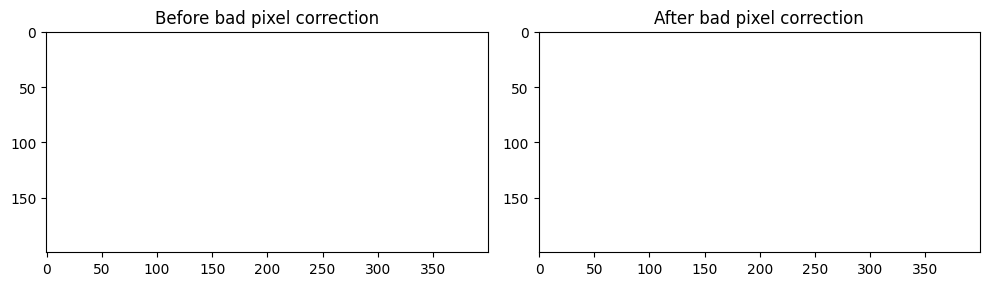

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
std_im = np.std(Im[0:200,0:400])
mean_im = np.mean(Im[0:200,0:400])
axes[0].imshow(Im[0:200,0:400],vmin=mean_im - 1*std_im, vmax=mean_im + 3*std_im)
axes[0].set_title("Before bad pixel correction")


#### Correction of hot pixels was moved after the diffraction subtraction. The diffraction pattern has too steep gradients
Med  = fast_nanmedian(Im, size=(3,3))                    # Median-filtered array for bad/hot pixels identification
BadPixIdx = np.absolute(Im-Med) > 15*np.sqrt(Var)      #eta2        # It fails and selects bright structures in the corona for synthetic and eclipse data
# BadPixIdx_mask = np.zeros((2048,2048)) ; BadPixIdx_mask[BadPixIdx] = 1
# plt.imshow(BadPixIdx_mask,origin='lower') ; plt.colorbar() ; plt.show()
#### Think about union of current BadPixIdx with repository-based HotPixels 
Im[BadPixIdx] = Med[BadPixIdx] 
##Im[HotPixels] = Med[HotPixels]

axes[1].imshow(Im[0:200,0:400],vmin=mean_im - 1*std_im, vmax=mean_im + 3*std_im)
axes[1].set_title("After bad pixel correction")
plt.tight_layout()
plt.show()

# plt.imshow(Im[0:200,0:400],vmin=-500,vmax=2000)
# plt.show()


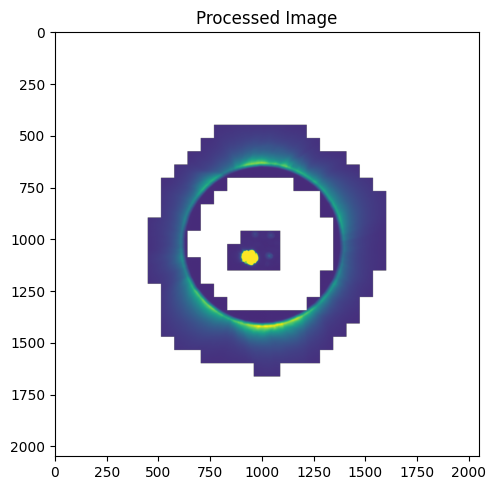

In [78]:
fig, ax = plt.subplots(1, figsize=(10, 5))
std_im = np.nanstd(Im)
mean_im = np.nanmean(Im)
ax.imshow(Im,vmin=mean_im - 1*std_im, vmax=mean_im + 3*std_im)
ax.set_title("Processed Image")
plt.tight_layout()
plt.show()

In [73]:
# tmpY,tmpZ = opse.aspiics_get_opse(Im,header,params,verbose=False,save_image=True)        # find position of the OPSE LEDs in the image
#sys.exit('exiting after OPSE')
#Im   = np.subtract(Im,optics.ghost(header,params))
#Im   = np.subtract(Im,np.multiply(optics.scatter(header,params),vign))
#Im   = np.subtract(Im,optics.diffraction(header,params,verbose=False))
#Im   = np.subtract(Im,optics.diffraction(header,params,verbose=False,diff_filename=DIFFR_filename))       # old-style, diffraction file passed by parameters
if args.save_diff:
    diff=optics.diffraction(header,params,verbose=False,diff_filename=DIFFR_filename)
    hdu=fits.PrimaryHDU(diff,header=header)
    diff_newfilename=os.path.basename(filename)
    diff_newfilename=diff_newfilename.replace("l0","l2")
    diff_newfilename=diff_newfilename+".diffraction.fits"
    print("%    Diffraction filename: **",diff_newfilename,"**",sep='')
    file2write = os.path.join(outputdir,diff_newfilename)
    print("%    Saving diffraction to "+file2write)
    hdu.writeto(file2write,checksum=True,overwrite=True)

#### Correction of hot pixels
Med  = ndimage.median_filter(Im,size=(3,3))                           # Median-filtered array for bad/hot pixels identification
BadPixIdx = np.absolute(Im-Med) > eta2*np.sqrt(Var)      #eta2        # It fails and selects bright structures in the corona for synthetic and eclipse data
BadPixIdx_mask = np.zeros((2048,2048)) ; BadPixIdx_mask[BadPixIdx] = 1 ;    #plt.imshow(BadPixIdx_mask,origin='lower') ; plt.colorbar() ; plt.show()    # Show masked
#plt.imshow(Med,origin='lower') ; plt.colorbar() ; plt.show()
#### Think about union of the current BadPixIdx with the repository-based HotPixels 
Im[BadPixIdx] = Med[BadPixIdx] 
#Im[HotPixels] = Med[HotPixels]

### Vignetting                                                                                     ###
#vign[vign < 1e-3] = 1e-3 ;  Im   = np.divide(Im,vign)

# here we should mark overexposed pixels
Im[OvrExpIdx] = np.inf #1.5e+30
Im[BlankIdx]  = np.nan
# finding min-max-mean-median
BadIdx = OvrExpIdx | BlankIdx                                         # mask for all the bad pixels
DATAMIN = np.min(Im[ ~ BadIdx])
DATAMAX = np.max(Im[ ~ BadIdx])
DATAMEAN = np.mean(Im[ ~ BadIdx])
DATAMEDN = np.median(Im[ ~ BadIdx])

if mark_io:
    xio1=np.rint(x_IO).astype(int)  ;  yio1=np.rint(y_IO).astype(int)
    Im[yio1,xio1-20:xio1+20] = DATAMAX
    Im[yio1-20:yio1+20,xio1] = DATAMAX
    print("Marking IO in the image: ", xio1, yio1)
    

if mark_sun:
    CRPIX1=header['CRPIX1']-1.  ;  CRPIX2=header['CRPIX2']-1.  ;  CRVAL1=header['CRVAL1']  ;  CRVAL2=header['CRVAL2']  ;  CDELT1=header['CDELT1']  ;  CDELT2=header['CDELT2']
    CROTA=header['CROTA']       ;  PC1_1=header['PC1_1']       ;  PC1_2=header['PC1_2']    ;  PC2_1=header['PC2_1']  ;  PC2_2=header['PC2_2']
    xSun = PC1_1*(-CRVAL1)/CDELT1 + PC2_1*(-CRVAL2)/CDELT2 + CRPIX1  # this is manual transformation (x,y)^ = rot()^  @  (dx/CDELT1, dy/CDELT2)^ + (CRPIX1,CRPIX2)^
    ySun = PC1_2*(-CRVAL1)/CDELT1 + PC2_2*(-CRVAL2)/CDELT2 + CRPIX2  # following Thompson 2006,  ^ -- transposition, @ - matrix multiplication
    xSunI=np.rint(xSun).astype(int)
    ySunI=np.rint(ySun).astype(int)
    Im[ySunI,xSunI-40:xSunI+40] = DATAMAX
    Im[ySunI-40:ySunI+40,xSunI] = DATAMAX
    print("Marking solar center in the image: ", xSun, ySun)
    header.set("SOLC_X",float("{:.2f}".format(xSun+1)),'expected position of x-Sun center (1..2048)')
    header.set("SOLC_Y",float("{:.2f}".format(ySun+1)),'expected position of y-Sun center (1..2048)')
    

### $$$ *********                                                                  ********* $$$ ###
### $$$ *********                        OK, NOW YOU CAN DO IT                     ********* $$$ ###
### $$$ *********                                                                  ********* $$$ ###

### ************ updating keywords ************** ###
del header['BLANK']
del header['BZERO']
del header['BSCALE']
header.set("HISTORY", bias_msg)
header.set("HISTORY", dc_msg)
header.set("HISTORY", nlcorr_msg)
header.set("HISTORY", flat_msg)
#header.set("HISTORY", vign_msg)
header.set("LEVEL", "L2")
header.set('VERS_CAL', params['calib_data']['VERS_CAL'], "version of set of calibration files")
header.set('BUNIT', "MSB", "obtained from [DN/s] dividing by A_PHOT")
header.set('A_phot', Aphot, "["+params['calib_data']['Aphot_units']+"] mean radiometric sensitivity")
header.set('X_IO', x_IO+1.0, "[pix] X position of the IO (1..2048)")
header.set('Y_IO', y_IO+1.0, "[pix] Y position of the IO (1..2048)")
header.set('R_IO', R_IO, "[mm] IO radius")
header.set('CONV_PHO', params['calib_data']['CONV_PHO'], "[DN/s]/CONV_PHO gives photon/s/cm2/sr")
header.set('CONV_WAT', params['calib_data']['CONV_PHO']/params['calib_data']['Photon_energy']/1.0e+4, "Conversion from DN/s to W/m2/sr")
header.set('CONV_ERG', params['calib_data']['CONV_PHO']/(params['calib_data']['Photon_energy']*1e+7), "Conversion from DN/s to erg/s/cm2/sr")
header.set('DATAMIN', DATAMIN, "minimum valid physical value")
header.set('DATAMAX', DATAMAX, "maximum valid physical value")
header.set('DATAMEAN', DATAMEAN, "average pixel value across the image")
header.set('DATAMEDN', DATAMEDN, "median pixel value across the image")
header.set('HISTORY',"MSB equals "+"{:10.4e}".format(params['calib_data']['MSB'])+" "+params['calib_data']['MSB_UNITS'])


### ********** convert to 32bit float ************ ###
Im = Im.astype(np.float32)


#if __name__ == '__main__':
#    parser = argparse.ArgumentParser()
#    parser.add_argument("-i", "--input", action="store", dest="inputfile")
#    parser.add_argument("-c", "--calibrationfile", action="store", dest="calibrationfile")
#    parser.add_argument("-o", "--outputdir", action="store", dest="outputdir")
#    parser.add_argument("-r", "--run_id", action="store", dest="run_id")
#    parser.add_argument("--opse", action="store_true")
#    parser.add_argument("--diffraction")
#    parser.add_argument("--ghost")
#    args = parser.parse_args()

### ********** setup output dir *******************
#outputdir = './output/'
#if os.path.exists(args.outputdir):
#  outputdir = args.outputdir


### ************* write down the final Im into fits ****
hdu=fits.PrimaryHDU(Im,header=header)
filename=os.path.basename(filename)
newname=filename.replace("l0","l2")
newname=filename.replace("l1","l2").replace(".fits",f"_{suffix}.fits")
#print("File to write: **",filename_parts[1],"**",filename_parts[2],"**")
file2write = os.path.join(outputdir,newname)
if os.path.isfile(file2write):
    print("% L2_MASTER. Output file "+file2write+" exists. Removing it")
    os.remove(file2write)
print("% L2_MASTER. Writing "+file2write)
hdu.writeto(file2write,checksum=True)
###

#plt.clf()
#plt.imshow(Im,origin='lower')
#plt.show()

#plt.figure("2D vs 1D nx1=128")
##plt.xscale('lin')
#plt.subplot(211)
#plt.yscale('log')
#plt.xlabel('Height, Mm')
#plt.ylabel('Rho, 1e+9 cm-3')
#plt.xlim(0,20)
#plt.ylim(1e-1,1e+4)



% L2_MASTER. Writing ./output/aspiics_wb_l2_1110A00A000112_20250716T190406_fixnonlin_flat_banding12_hotpix.fits
